In [1]:
!pip install zarr
!pip install -U xarray

     |████████████████████████████████| 153 kB 14.6 MB/s 
     |████████████████████████████████| 6.2 MB 84.7 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=1976646e1bc8ecb359d48bb94dc3e9c49e21a8c8c56aeb178672d1acc52fe25d
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree
     |████████████████████████████████| 845 kB 14.1 MB/s 
  Attempting uninstall: xarray
    Found existing installation: xarray 0.18.2
    Uninstalling xarray-0.18.2:
      Successfully uninstalled xarray-0.18.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/syde770')

Mounted at /content/drive


In [23]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from model import spatial_feature_pyramid_net_hiddenstate_ND, spatial_feature_pyramid_net_vectorized_ND

from model_tester import *

def masked_MSE(mask):
    def loss(y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        sq_diff = tf.multiply(tf.math.squared_difference(y_pred, y_true), mask)
        return tf.reduce_mean(sq_diff)
    return loss

def masked_MAE(mask):
    def loss(y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        ab_diff = tf.multiply(tf.math.abs(tf.math.subtract(y_pred, y_true)), mask)
        return tf.reduce_mean(ab_diff)
    return loss

class Climatology:
    def __init__(self):
        pass

    def fit(self, y, dates):
        self.climatologies = xr.DataArray(
            y[:, 0, :, :, 0],
            dims=['time', 'y', 'x'],
            coords={'time': dates}
            ).groupby('time.month').mean()
        
    def predict(self, dates):
        pred_y = xr.DataArray(np.zeros(shape=len(dates)), coords={'time': dates}).groupby('time.month') + self.climatologies
        return np.expand_dims(pred_y.to_numpy(), [1, -1])

class Persistence:
    def __init__(self):
        pass
    
    # def predict(self, X):
    #     """X.shape: (num_features, timesteps, x, y, features) where features[0] is siconc"""
    #     return X[:, -1:, :, :, 0:1]

    def predict(self, X):
        return np.array([X[0]] + list(X[:-1]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
ds = xr.open_zarr('data_full.zarr')
ds = xr.concat([
    ds.sel(time=slice(None, datetime.datetime(2011, 9, 30))), 
    ds.sel(time=slice(datetime.datetime(2012, 10, 1), None))
    ], dim='time')

In [7]:
test_size = 0.3
deseasonalize = False
only_winter = True
weekly = False
binary_sic = False
only_polynya = True

def split_time(ds, test_size):
    idx = int(len(ds.time) * (1 - test_size))
    train, test = ds.isel(time=slice(None, idx)), ds.isel(time=slice(idx, None))
    return train, test

def is_winter(month):
    return (month >= 1) & (month < 5)

# Read and drop unnecessary variables
ds = xr.open_zarr('data.zarr')
ds = ds.drop(['Lambert_Azimuthal_Grid', 'status_flag', 'ceda_sic_bin', 'era5_sic', 'era5_sic_bin', 'total_standard_error'])

if weekly:
    ds = ds.resample(time='W').mean()

# Split by time into train & test
train, test = split_time(ds, test_size)

# Include only winter, if desired
if only_winter:
    train = train.sel(time=is_winter(train['time.month']))
    test = test.sel(time=is_winter(test['time.month']))

if only_polynya:
    train = train.isel(x=slice(-32, None), y=slice(None, 32))
    test = test.isel(x=slice(-32, None), y=slice(None, 32))
    
unscaled_sic_train, unscaled_sic_test = train.ceda_sic.values, test.ceda_sic.values

# Deseasonalize, if desired
if deseasonalize:
    climatologies = train.groupby('time.dayofyear').mean()
    train = train.groupby('time.dayofyear') - climatologies
    test = test.groupby('time.dayofyear') - climatologies

# Transform into np.array
train_array, test_array = train.to_array().to_numpy(), test.to_array().to_numpy()

# Apply (pseudo-)landmask
nan_mask = np.isnan(train_array[0][0])

# Scaling
scaler = StandardScaler()
train_array = scaler.fit_transform(train_array.reshape(-1, np.prod(train_array.shape[1:])).T).T.reshape(train_array.shape)
test_array = scaler.transform(test_array.reshape(-1, np.prod(test_array.shape[1:])).T).T.reshape(test_array.shape)

if binary_sic:
    train_array[0] = apply_tresh(unscaled_sic_train, 85).astype(int)
    test_array[0] = apply_tresh(unscaled_sic_test, 85).astype(int)
        
# Replace NaNs with 0s 
train_array, test_array = np.nan_to_num(train_array), np.nan_to_num(test_array)

In [8]:
# Create timesteps
num_timesteps = 3
num_timesteps_predict = 1
gap = 0

predict_only_sic = True

def create_timesteps(arr, num_timesteps=3):
    timesteps = [arr[:-(num_timesteps - 1)]]
    
    for i in range(1, num_timesteps - 1):
        timesteps.append(arr[i:-((num_timesteps-1)-i)])
                 
    timesteps.append(arr[(num_timesteps - 1):])
    return np.array(timesteps)

train_X = np.transpose(train_array, axes=[1, 2, 3, 0])
train_X = create_timesteps(train_X, num_timesteps + gap + num_timesteps_predict)
train_X = np.transpose(train_X, axes=[1, 0, 2, 3, 4])

test_X = np.transpose(test_array, axes=[1, 2, 3, 0])
test_X = create_timesteps(test_X, num_timesteps + gap + num_timesteps_predict)
test_X = np.transpose(test_X, axes=[1, 0, 2, 3, 4])

# Split x and y
train_Y = train_X[:, -(num_timesteps_predict):, :, :, :]  # 0th variable is SIC
test_Y = test_X[:, -(num_timesteps_predict):, :, :, :]  # 0th variable is SIC

train_X = train_X[:, :num_timesteps, :, :, :]
test_X = test_X[:, :num_timesteps, :, :, :]

dates_train = train.time[num_timesteps + gap:]
dates_test = test.time[num_timesteps + gap:]

if predict_only_sic:
    train_Y = np.expand_dims(train_Y[..., 0], -1)
    test_Y = np.expand_dims(test_Y[..., 0], -1)

print(f'{train_X.shape}')
print(f'{train_Y.shape}')
print(f'{test_X.shape}')
print(f'{test_Y.shape}')

(764, 3, 32, 32, 6)
(764, 1, 32, 32, 1)
(313, 3, 32, 32, 6)
(313, 1, 32, 32, 1)


In [9]:
model = spatial_feature_pyramid_net_hiddenstate_ND(
    input_shape=(num_timesteps, *train_X.shape[2:]),
    output_steps=1,
)
loss = masked_MSE(mask=np.expand_dims(~nan_mask, [0, -1]))
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=0.01))

(None, 1, 32, 32, 16)
(None, 1, 32, 32, 8)
(None, 1, 32, 32, 1)


In [10]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 64

# Train
history = model.fit(
    train_X,
    train_Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_X, test_Y),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

Epoch 1/100
12/12 [==============================] - 17s 183ms/step - loss: 0.8020 - val_loss: 0.5595 - lr: 0.0100
Epoch 2/100
12/12 [==============================] - 1s 104ms/step - loss: 0.4400 - val_loss: 0.4436 - lr: 0.0100
Epoch 3/100
12/12 [==============================] - 1s 103ms/step - loss: 0.3591 - val_loss: 0.3771 - lr: 0.0100
Epoch 4/100
12/12 [==============================] - 1s 103ms/step - loss: 0.3086 - val_loss: 0.3285 - lr: 0.0100
Epoch 5/100
12/12 [==============================] - 1s 104ms/step - loss: 0.2698 - val_loss: 0.2957 - lr: 0.0100
Epoch 6/100
12/12 [==============================] - 1s 103ms/step - loss: 0.2465 - val_loss: 0.2736 - lr: 0.0100
Epoch 7/100
12/12 [==============================] - 1s 103ms/step - loss: 0.2299 - val_loss: 0.2575 - lr: 0.0100
Epoch 8/100
12/12 [==============================] - 1s 103ms/step - loss: 0.2179 - val_loss: 0.2455 - lr: 0.0100
Epoch 9/100
12/12 [==============================] - 1s 114ms/step - loss: 0.2116 - val

In [14]:
nan_mask_reshaped = np.expand_dims(~nan_mask, [0, -1])
df = pd.DataFrame(index=['Train MAE', 'Train MSE', 'Test MAE', 'Test MSE'])

results = {}

# NN
results['NN'] = {}
results['NN']['Train'] = model.predict(train_X)
results['NN']['Test'] = model.predict(test_X)

# Persistence
results['Persistence'] = {}
results['Persistence']['Train'] = Persistence().predict(train_X)
results['Persistence']['Test'] = Persistence().predict(test_X)

# Climatology
clim = Climatology()
clim.fit(train_Y, dates_train)
results['Climatology'] = {}
results['Climatology']['Train'] = clim.predict(dates_train)
results['Climatology']['Test'] = clim.predict(dates_test)


for model_name, scores in results.items():
    df[model_name] = [
        masked_MAE(nan_mask_reshaped)(train_Y, scores['Train']).numpy(),
        masked_MSE(nan_mask_reshaped)(train_Y, scores['Train']).numpy(),
        masked_MAE(nan_mask_reshaped)(test_Y, scores['Test']).numpy(),
        masked_MSE(nan_mask_reshaped)(test_Y, scores['Test']).numpy(),
    ]
  

df.round(3)

,NN,Persistence,Climatology
Train MAE,0.155,0.159,0.296
Train MSE,0.149,0.162,0.386
Test MAE,0.163,0.152,0.355
Test MSE,0.175,0.190,0.543


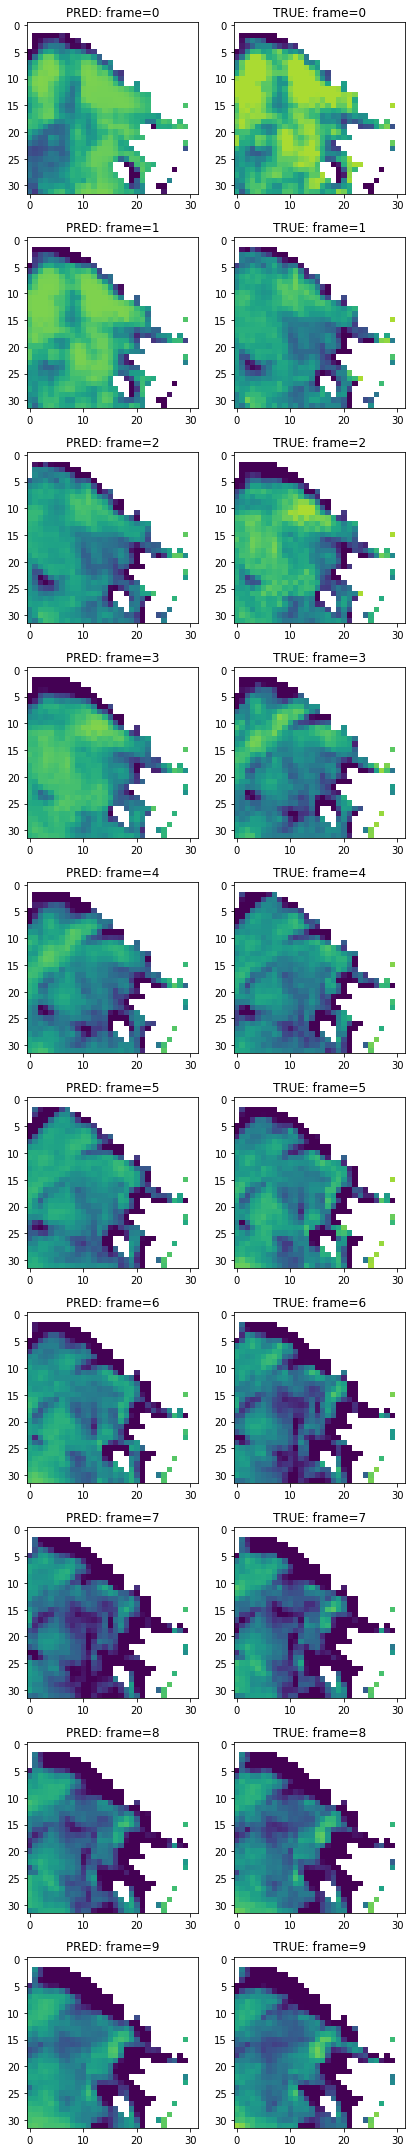

In [12]:
num_frames = 10
i_start = 0
set_ = 'train'

# model_to_test = Persistence()
model_to_test = model

if set_ == 'train':
    pred = model_to_test.predict(train_X[i_start:i_start + num_frames])
    tru = train_Y[i_start:i_start + num_frames]
elif set_ == 'test':
    pred = model_to_test.predict(test_X[i_start:i_start + num_frames])
    tru = test_Y[i_start:i_start + num_frames]

fig, axs = plt.subplots(num_frames, 2, figsize=(6, num_frames * 3))

for j in range(num_frames):
    axs[j][0].imshow(np.ma.masked_where(nan_mask, pred[j, 0, :, :, 0]), vmin=-1, vmax=1)
    axs[j][0].set_title(f'PRED: frame={j}')
    axs[j][1].imshow(np.ma.masked_where(nan_mask, tru[j, 0, :, :, 0]), vmin=-1, vmax=1)
    axs[j][1].set_title(f'TRUE: frame={j}')
        
plt.tight_layout()

In [ ]:
model_tester.tra

In [26]:
save_dir = '/content/drive/MyDrive/syde770/save_dir_sifnet/'
model_tester = ModelTester()

i = 0
num_timesteps = 4
model_tester.preprocess_data(
    ds,
    weekly=True,
    num_timesteps=num_timesteps,
    gap=0,
    )

model_name = 'test1'

filename = save_dir + model_name

model = spatial_feature_pyramid_net_hiddenstate_ND(
    input_shape=(num_timesteps, *train_X.shape[2:]),
    output_steps=1,
)
loss = masked_MSE(mask=np.expand_dims(~nan_mask, [0, -1]))
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=0.01))
model_tester.model = model

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 500
batch_size = 10

# Train
history = model_tester.model.fit(
    model_tester.train_X,
    model_tester.train_Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(model_tester.test_X, model_tester.test_Y),
    # callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

model_tester.save(model_name, save_dir)

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(None, 1, 32, 32, 16)
(None, 1, 32, 32, 8)
(None, 1, 32, 32, 1)
Epoch 1/500
11/11 [==============================] - 5s 107ms/step - loss: 0.7126 - val_loss: 0.6174
Epoch 2/500
11/11 [==============================] - 0s 45ms/step - loss: 0.5290 - val_loss: 0.5612
Epoch 3/500
11/11 [==============================] - 0s 43ms/step - loss: 0.4699 - val_loss: 0.5017
Epoch 4/500
11/11 [==============================] - 0s 43ms/step - loss: 0.4315 - val_loss: 0.5183
Epoch 5/500
11/11 [==============================] - 0s 44ms/step - loss: 0.4199 - val_loss: 0.4669
Epoch 6/500
11/11 [==============================] - 0s 45ms/step - loss: 0.4229 - val_loss: 0.4683
Epoch 7/500
11/11 [==============================] - 0s 44ms/step - loss: 0.3922 - val_loss: 0.4537
Epoch 8/500
11/11 [==============================] - 0s 44ms/step - loss: 0.3857 - val_loss: 0.4591
Epoch 9/500
11/11 [==============================] - 0s 43ms/step - loss: 0.3920 - val_loss: 0.4592
Epoch 10/500
11/11 [===============

INFO:tensorflow:Assets written to: /content/drive/MyDrive/syde770/save_dir_sifnet/test1_model.p/assets


In [27]:
model_tester.get_results()

1


,NN,Persistence,Climatology
Train MAE,2.158222,5.467501,2.184878
Train RMSE,4.627039,10.649601,4.674635
Test MAE,2.548396,5.829986,2.292640
Test RMSE,5.420925,10.903217,4.784491
